In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SMO import SMO
%matplotlib inline 

在两个中心用不同的协方差矩阵生成两类点

用SVM做分类，中间的求alpha过程借鉴改写了别人的SMO实现

求最优b的过程可能有一些问题，但我是对照这个图片来的

![SVM](./SVM.png)

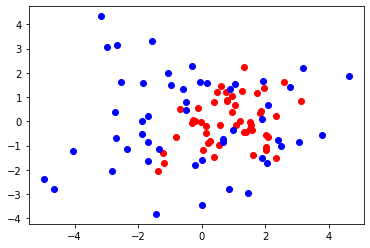

In [2]:
# 生成点
A_mean = [1,0]
A_cov = [[1,0],[0,1]]

B_mean = [0,0]
B_cov = [[5,0],[0,5]]

A_data = np.random.multivariate_normal(A_mean, A_cov, 50)
A_x1, A_x2= A_data.T

B_data = np.random.multivariate_normal(B_mean, B_cov, 50)
B_x1, B_x2= B_data.T

plt.scatter(A_x1, A_x2, c='r')
plt.scatter(B_x1, B_x2, c='b')

(-4.229462098758738, 4.739616202768933)

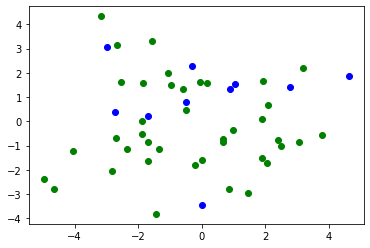

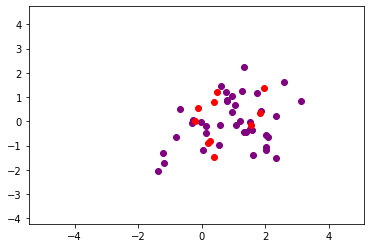

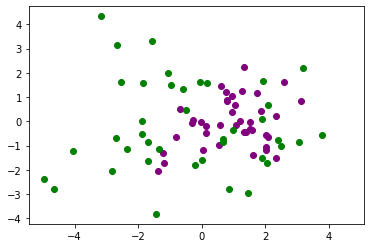

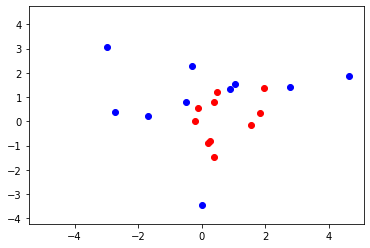

In [3]:
# 各取1/5留作测试
# 蓝色为B类测试集，绿色为B类训练集
# 红色为A类测试集，紫色为A类训练集
A_train = A_data[10:]
A_test = A_data[:10]
A_tra_x1, A_tra_x2 = A_train.T
A_test_x1, A_test_x2 = A_test.T

B_train = B_data[10:]
B_test = B_data[:10]
B_tra_x1, B_tra_x2 = B_train.T
B_test_x1, B_test_x2 = B_test.T

# B类数据集
plt.figure()
plt.scatter(B_tra_x1, B_tra_x2, c='g')
plt.scatter(B_test_x1, B_test_x2, c='b')
axes = plt.gca()

# A类数据集
plt.figure()
plt.scatter(A_tra_x1, A_tra_x2, c='purple')
plt.scatter(A_test_x1, A_test_x2, c='r')
plt.xlim(axes.get_xlim())
plt.ylim(axes.get_ylim())

# 训练集
plt.figure()
plt.scatter(A_tra_x1, A_tra_x2, c='purple')
plt.scatter(B_tra_x1, B_tra_x2, c='g')
plt.xlim(axes.get_xlim())
plt.ylim(axes.get_ylim())

# 测试集
plt.figure()
plt.scatter(A_test_x1, A_test_x2, c='r')
plt.scatter(B_test_x1, B_test_x2, c='b')
plt.xlim(axes.get_xlim())
plt.ylim(axes.get_ylim())

In [4]:
# 合并训练集
tra_A = pd.DataFrame(A_train, columns=['x1','x2'])
tra_A['y'] = 1
tra_B = pd.DataFrame(B_train, columns=['x1','x2'])
tra_B['y'] = -1
tra = pd.concat([tra_A, tra_B], ignore_index=True)

In [5]:
# 合并测试集
test_A = pd.DataFrame(A_test, columns=['x1','x2'])
test_A['y'] = 1
test_B = pd.DataFrame(B_test, columns=['x1','x2'])
test_B['y'] = -1
test = pd.concat([test_A, test_B], ignore_index=True)

In [6]:
# 定义多项式核函数
def poly_kernel(x1, x2):
    return (sum([x1[k] * x2[k] for k in range(len(x1))]) + 1) ** 2

# 定义线性核函数
def linear_kernel(x1, x2):
    return sum([x1[k] * x2[k] for k in range(len(x1))])
    

In [7]:
# 定义SVM
class SVM:
    def __init__(self, kernel, tra_X, tra_y):
        # 使用SMO求解alpha*
        self.X = tra_X
        self.y = tra_y
        self.smo = SMO(kernel, max_iter=5000)
        self.alpha = self.smo.fit(np.array(tra[['x1','x2']]), np.array(tra['y']))
        print("alpha为：", self.alpha)
        self.kernel = kernel

    # 求解b*
    def b_star(self):
        index = -1
        b = 0
        minus = 0
        for i in range(len(self.alpha)):
            if 0 < self.alpha[i] < 1:
                index = i
                break
        if index != -1:
            for i in range(len(tra)):
                minus += self.alpha[i] * self.y[i] * self.kernel(self.X[i], self.X[index])
            b = self.y[index] - minus
        return b

    # 预测
    def predict(self, data):
        r = self.b_star()
        for i in range(len(self.X)):
            r += self.alpha[i] * self.y[i] * self.kernel(data, self.X[i])
        return 1 if r > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            result = self.predict(X_test[i])
            if result == y_test[i]:
                right_count += 1
        return right_count / len(X_test)


X_test = np.array(test[['x1','x2']])
y_test = np.array(test['y'])

svm = SVM(linear_kernel, np.array(tra[['x1','x2']]), np.array(tra['y']))
print("线性核：",svm.score(X_test, y_test))
svm = SVM(poly_kernel, np.array(tra[['x1','x2']]), np.array(tra['y']))
print("多项式核：",svm.score(X_test, y_test))

alpha为： [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
线性核： 0.7
alpha为： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
多项式核： 0.5
